## Análisis de la fuente

Tenemos una fuente en MongoDB con las propiedades provenientes del sitio cabaprop.

Esta fuente tiene los siguientes campos en formato json

```python
{
    ambience_types: { # Contiene booleanos caracterizando los cambientes del inmueble
        palier_comun: bool,
        palier_privado: bool,
        palier_semi_privado: bool,
        hall: bool,
        living: bool,
        living_comedor: bool,
        comedor: bool,
        comedor_diario: bool,
        escritorio: bool,        
        dormitorio_en_suite: bool,
        cocina_completa: bool,
        cocina_integrada: bool,
        cocina_kitchenette: bool,
        cocina_americana: bool,
        vestidor: bool,
        pasillo: bool,
        dependencia_de_servicio: bool,
        bano_de_servicio: bool,
        jardin: bool,
        patio: bool,
        baulera: bool,
        balcon: bool
    },
    antiquity: { # Antiguedad del inmueble
        years: int
    },
    description: string, # Descripción del inmueble
    title: string, # Título de la publicación
    price: { # Objeto de precio
        currency: int, # 1: USD, 2: ARS
        total: string, # Precio del inmueble
        expenses: string, # Expensas
        expensesCurrency: int # 1: USD, 2: ARS
    },
    location: { # Objeto de ubicación, contiene muchos datos, solo nos van a importar algunos datos
        letter: string,
        number: int,
        street: string,
        barrios: Array, # Array de 1 solo elemento, ver "barrios.ts" para ver a que se refiere c/u
        lat: double,
        lng: double,
        locality: string, # Ej: Buenos Aires
    },
    characteristics: { #Características del inmueble
        ambience: int, # Cantidad de ambientes
        bedrooms: int, # Cantidad de cuartos
        bathrooms: int, # Cantidad de baños
        privateBathroom: bool, # Si tiene baño privado
        toilettes: int, 
        floors: int, #Pisos del edificio
        apartments: int, #Departamentos por piso
        covered: bool,
        lift: bool,
        underground: bool,
        building: bool,
        accessibilities: bool,
        inhabited: bool,
        hasPoster: bool,
        laundry: { # Los siguientes los podríamos convertir
            active: bool, 
        },
        balcony: {
            active: bool, 
        },
        yard: {
            active: bool, 
        },
        rooftop: {
            active: bool, 
        },
        garages: {
            active: bool, 
        }
    }
    extras: { # Info extra
        serviciosEsenciales: {
            abl: bool,
            aysa: bool,
            gas: bool,
            electricidad: bool,
            internet_wifi: bool,
            tv_cable: bool,
            telefono: bool,
            agua_corriente: bool
        },
        vista: { # Objeto con info de vista
            calle: bool,
            pulmonManzana: bool,
            jardin: bool,
            plaza: bool,
            abierta: bool
        },
        seguridad: { # Objeto con info de seguridad
            alarma: bool,
            puertaBlindada: bool,
            grupoElectrogeno: bool
        }
        calefaccion: { # Objeto con info de calefacción
            ...
        },
        vigilancia: { # Objeto con info de vigilancia
            ...
        },
        adicionales: {
            termotanque_electrico: bool,
            termotanque_gas: bool,
            cocina_electrica: bool,
            cocina_gas: bool,
            amoblado: bool,
            placards: bool,
            cancha_paddle: bool,
            cancha_tenis: bool,
            gimnasio: bool,
            hidromasaje: bool,
            laundry: bool,
            microcine: bool,
            parrilla: bool,
            piscina: bool,
            sala_de_juegos: bool,
            sauna: bool,
            solarium: bool,
            spa: bool,
            sum: bool,
            centros_comerciales_cercanos: bool,
            escuelas_cercanas: bool,
            parques_cercanos: bool,
            estacionamiento_visitas: bool
        }
    },
    surface: { #Información de superficie
        totalSurface: int,
        coveredSurface: int,
        uncoveredSurface: int,
        semiCoveredSurface: int,
        exclusiveSurface: int
    },
    operation_type: int # Tipo de operación 1: Venta, 2: Alquiler, 3: Temporario
    property_type: int # Tipo de propiedad 1: Departamento, 2: Casa, 3: PH, hay más pero nos interesan esos.
    ... # Hay más campos pero nos interesarían solo los de arriba
}
``` 

In [8]:
import pymongo
import urllib.parse
import certifi
from pymongo.mongo_client import MongoClient
import json
import os
import pandas as pd
import requests
import random

pd.set_option('display.max_columns', None)

username = urllib.parse.quote_plus(os.getenv("MONGO_USERNAME"))
password = urllib.parse.quote_plus(os.getenv("MONGO_PASSWORD"))

uri = "mongodb://{}:{}@{}:{}/?authSource={}&authMechanism={}".format(username, password, os.getenv("MONGO_HOST"),
                                            os.getenv("MONGO_PORT"), os.getenv("MONGO_DATABASE"), "SCRAM-SHA-1")

client = MongoClient(uri)

try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [19]:
db = client[os.getenv("MONGO_DATABASE")]
cabaprop_collection = db.CabapropStaging

# Debido a que el tipo de operación esta embebido en el campo "attributes" vamos a tener
# que importar todo y filtrar luego

operation_ids = [2,3]
property_ids = [1,2,3]


propiedades = cabaprop_collection.find({
    "operation_type": {"$in": operation_ids},
    "property_type": {"$in": property_ids}
    })
print(cabaprop_collection.count_documents({
    "operation_type": {"$in": operation_ids},
    "property_type": {"$in": property_ids}
    }))

2298


In [20]:
propiedades

In [24]:
# Debido a que tenemos muchos objetos en la entrada y no necesitamos todos, vamos a
# Realizar un loop para solo quedarnos con las cosas que necesitamos

propiedades_list = list()

len_propiedades = len(propiedades_list)
# No todas las columnas nos van a importar, hay que pensar que esta es información
# que vamos a pedirle luego a los usuarios para realizar la predicción.

# Notar que este análisis se hizo en base de la matriz de correlación de las variables

for p in propiedades:
    propiedades_list.append({
        "_id": p["_id"],
        "characteristincs_balcony": p["characteristics"]["balcony"]["active"],
        "characteristincs_yard": p["characteristics"]["yard"]["active"],
        "characteristincs_rooftop": p["characteristics"]["rooftop"]["active"],
        "characteristincs_garage": p["characteristics"]["garages"]["active"],
        "amenities_amoblado": p["extras"]["adicionales"]["amoblado"],
        "amenities_cancha_paddle": p["extras"]["adicionales"]["cancha_paddle"],
        "amenities_cancha_tenis": p["extras"]["adicionales"]["cancha_tenis"],
        "amenities_gimnasio": p["extras"]["adicionales"]["gimnasio"],
        "amenities_hidromasaje": p["extras"]["adicionales"]["hidromasaje"],
        "amenities_laundry": p["extras"]["adicionales"]["laundry"],
        "amenities_microcine": p["extras"]["adicionales"]["microcine"],
        "amenities_parrilla": p["extras"]["adicionales"]["parrilla"],
        "amenities_piscina": p["extras"]["adicionales"]["piscina"],
        "amenities_sala_de_juegos": p["extras"]["adicionales"]["sala_de_juegos"],
        "amenities_sauna": p["extras"]["adicionales"]["sauna"],
        "amenities_solarium": p["extras"]["adicionales"]["solarium"],
        "amenities_spa": p["extras"]["adicionales"]["spa"],
        "amenities_sum": p["extras"]["adicionales"]["sum"],
        "amenities_estacionamiento_visitas": p["extras"]["adicionales"]["estacionamiento_visitas"],
        "antiquity": p["antiquity"]["years"],
        "description": p["description"],
        "title": p["title"],
        "price": p["price"]["total"],
        "price_currency": p["price"]["currency"],
        "expenses": p["price"]["expenses"],
        "expenses_currency": p["price"]["expensesCurrency"],
        "location_number": p["location"]["number"],
        "location_street": p["location"]["street"],
        "location_neighbourhood": p["location"]["barrios"][0],
        "location_lat": p["location"]["lat"],
        "location_lng": p["location"]["lng"],
        "location_locality": p["location"]["locality"],
        "ambience": p["characteristics"]["ambience"],
        "bedrooms": p["characteristics"]["bedrooms"],
        "bathrooms": p["characteristics"]["bathrooms"],
        "surface_total": p["surface"]["totalSurface"],
        "surface_covered": p["surface"]["coveredSurface"],
        "surface_uncovered": p["surface"]["uncoveredSurface"],
        "centros_comerciales_cercanos": p["extras"]["adicionales"]["centros_comerciales_cercanos"],
        "parques_cercanos": p["extras"]["adicionales"]["parques_cercanos"],
        "escuelas_cercanas": p["extras"]["adicionales"]["escuelas_cercanas"],
        "property_type": p["property_type"],
        "operation_type": p["operation_type"]
    })

In [91]:
len(propiedades_list)

4051

In [92]:
import pandas as pd
import numpy as np
import json

pd.set_option('display.max_columns', None)
df_propiedades = pd.DataFrame(propiedades_list)
#df_propiedades.to_csv("source_raw.csv")

<Axes: title={'center': 'Distribución de tipos de propiedades'}, ylabel='proportion'>

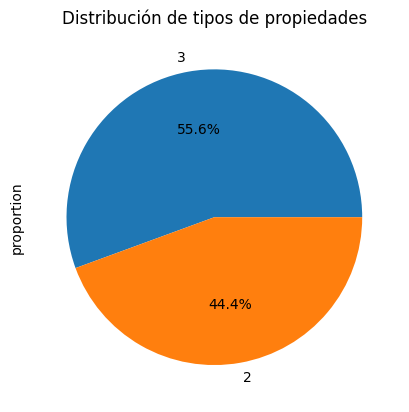

In [93]:
def my_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 3 else ''

df_propiedades['operation_type'].value_counts(normalize=True).plot.pie(autopct = my_autopct, title="Distribución de tipos de propiedades", legend=False)

In [94]:
df_propiedades['property_type'].value_counts(normalize=True) * 100

property_type
1    93.952111
2     3.826216
3     2.221674
Name: proportion, dtype: float64

In [95]:
df_propiedades.price = pd.to_numeric(df_propiedades.price, errors="coerce")
df_propiedades.expenses = pd.to_numeric(df_propiedades.expenses, errors="coerce")

df_propiedades = df_propiedades.astype({"price": int, "price": int})
df_propiedades

,_id,characteristincs_balcony,characteristincs_yard,characteristincs_rooftop,characteristincs_garage,amenities_amoblado,amenities_cancha_paddle,amenities_cancha_tenis,amenities_gimnasio,amenities_hidromasaje,amenities_laundry,amenities_microcine,amenities_parrilla,amenities_piscina,amenities_sala_de_juegos,amenities_sauna,amenities_solarium,amenities_spa,amenities_sum,amenities_estacionamiento_visitas,antiquity,description,title,price,price_currency,expenses,expenses_currency,location_number,location_street,location_neighbourhood,location_lat,location_lng,location_locality,ambience,bedrooms,bathrooms,building_floors,building_apartments_floor,surface_total,surface_covered,surface_uncovered,centros_comerciales_cercanos,parques_cercanos,escuelas_cercanas,property_type,operation_type
0,64d0a702d7bb11178d07713d,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-100,Alquilo Temporario en PALERMO.\r\n\r\nOportuni...,"HERMOSO DEPARTAMENTO AMOBLADO, 2 AMBIENTES, EN...",29000,2,NaN,2,NaN,Gral M Soler 4000,47,-34.591701,-58.417802,Buenos Aires,NaN,NaN,1,NaN,NaN,1,NaN,NaN,False,False,False,1,3
1,64d0a52bd7bb11178d076e7e,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-100,"PH con entrada independiente, primer piso por ...","Ph 5 Amb. V. Luro, Av. Rivadavia 8980 Uso Come...",240000,2,NaN,2,NaN,Rivadavia 8900,39,NaN,NaN,Buenos Aires,6.0,5.0,1,NaN,NaN,1,NaN,NaN,False,False,False,3,2
2,64d0a55cd7bb11178d076eda,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-100,Alquiler de Departamento MONOAMBIENTE en Barri...,(BUY-BUY-662) Departamento - Alquiler - Argent...,0,2,NaN,2,NaN,"LAPRIDA 1500, Piso 7",10,-34.591321,-58.404395,Buenos Aires,1.0,0.0,1,NaN,NaN,1,NaN,NaN,False,False,False,1,2
3,64d0a7fcd7bb11178d077317,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,Alquiler Excelente 2 amb c/ Balcón Frances- 33...,ALQUILER de Excelente 2 amb c/ Balcón Frances-...,60000,2,5700.0,2,2500.0,Alsina,6,-34.612262,-58.401468,Buenos Aires,2.0,1.0,1,NaN,NaN,33,33.0,0.0,False,False,False,1,2
4,64d0a623d7bb11178d076ffa,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,70,"Alquiler temporario \nImpecable monoambiente, ...",Alquiler Temporario,24000,2,0.0,2,300.0,Lavalle,41,-34.601949,-58.371087,Buenos Aires,1.0,0.0,1,12.0,8.0,26,26.0,0.0,False,False,False,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4046,64d10c02d7bb11178d0870a1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-100,Hermoso departamento de 1 ambiente planta baja...,Departamento En Villa Ortuzar,100000,2,NaN,2,NaN,Charlone al 2100,81,NaN,NaN,Buenos Aires,1.0,NaN,1,NaN,NaN,1,NaN,NaN,False,False,False,1,2
4047,64d10c02d7bb11178d0870a2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-100,Departamento de 2 ambientes al frente con balc...,Departamento En Alquiler,170000,2,NaN,2,NaN,Av. Olazabal al 4800,87,NaN,NaN,Buenos Aires,2.0,1.0,1,NaN,NaN,1,NaN,NaN,False,False,False,1,2
4048,64d10c13d7bb11178d0870d3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,Departamento en Piso 17. Semipiso de 250 m2 5 ...,Departamento en alquiler en belgrano,3000,1,150000.0,2,1641.0,arcos,14,-34.564514,-58.449982,Buenos Aires,5.0,4.0,1,NaN,NaN,250,250.0,0.0,False,False,False,1,2
4049,64d10c3dd7bb11178d087149,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-100,#EXCELENTE APARTAMENTO EN CANITAS CERCA 

In [96]:
# Primero que nada, sabemos que hay precios en pesos y dolares, por lo que debemos normalizar esta información

# Obtenemos el precio del dolar
import requests
res = requests.get("https://dolarapi.com/v1/dolares/blue")
dolar_blue = res.json()["compra"]

def convertir_a_pesos(currency, precio):
    if currency == 2:
        return precio/dolar_blue
    else:
        return precio

df_propiedades
df_propiedades.price = df_propiedades.apply(lambda row: convertir_a_pesos(row["price_currency"], row["price"]), axis=1)
df_propiedades.expenses = df_propiedades.apply(lambda row: convertir_a_pesos(row["expenses_currency"], row["expenses"]), axis=1)

# Borramos las columnas de Currency, ya que no las utiliazríamos mas
df_propiedades.drop(["price_currency", "expenses_currency"], axis=1, inplace=True)
df_propiedades



,_id,characteristincs_balcony,characteristincs_yard,characteristincs_rooftop,characteristincs_garage,amenities_amoblado,amenities_cancha_paddle,amenities_cancha_tenis,amenities_gimnasio,amenities_hidromasaje,amenities_laundry,amenities_microcine,amenities_parrilla,amenities_piscina,amenities_sala_de_juegos,amenities_sauna,amenities_solarium,amenities_spa,amenities_sum,amenities_estacionamiento_visitas,antiquity,description,title,price,expenses,location_number,location_street,location_neighbourhood,location_lat,location_lng,location_locality,ambience,bedrooms,bathrooms,building_floors,building_apartments_floor,surface_total,surface_covered,surface_uncovered,centros_comerciales_cercanos,parques_cercanos,escuelas_cercanas,property_type,operation_type
0,64d0a702d7bb11178d07713d,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-100,Alquilo Temporario en PALERMO.\r\n\r\nOportuni...,"HERMOSO DEPARTAMENTO AMOBLADO, 2 AMBIENTES, EN...",30.208333,NaN,NaN,Gral M Soler 4000,47,-34.591701,-58.417802,Buenos Aires,NaN,NaN,1,NaN,NaN,1,NaN,NaN,False,False,False,1,3
1,64d0a52bd7bb11178d076e7e,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-100,"PH con entrada independiente, primer piso por ...","Ph 5 Amb. V. Luro, Av. Rivadavia 8980 Uso Come...",250.000000,NaN,NaN,Rivadavia 8900,39,NaN,NaN,Buenos Aires,6.0,5.0,1,NaN,NaN,1,NaN,NaN,False,False,False,3,2
2,64d0a55cd7bb11178d076eda,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-100,Alquiler de Departamento MONOAMBIENTE en Barri...,(BUY-BUY-662) Departamento - Alquiler - Argent...,0.000000,NaN,NaN,"LAPRIDA 1500, Piso 7",10,-34.591321,-58.404395,Buenos Aires,1.0,0.0,1,NaN,NaN,1,NaN,NaN,False,False,False,1,2
3,64d0a7fcd7bb11178d077317,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,Alquiler Excelente 2 amb c/ Balcón Frances- 33...,ALQUILER de Excelente 2 amb c/ Balcón Frances-...,62.500000,5.9375,2500.0,Alsina,6,-34.612262,-58.401468,Buenos Aires,2.0,1.0,1,NaN,NaN,33,33.0,0.0,False,False,False,1,2
4,64d0a623d7bb11178d076ffa,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,70,"Alquiler temporario \nImpecable monoambiente, ...",Alquiler Temporario,25.000000,0.0000,300.0,Lavalle,41,-34.601949,-58.371087,Buenos Aires,1.0,0.0,1,12.0,8.0,26,26.0,0.0,False,False,False,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4046,64d10c02d7bb11178d0870a1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-100,Hermoso departamento de 1 ambiente planta baja...,Departamento En Villa Ortuzar,104.166667,NaN,NaN,Charlone al 2100,81,NaN,NaN,Buenos Aires,1.0,NaN,1,NaN,NaN,1,NaN,NaN,False,False,False,1,2
4047,64d10c02d7bb11178d0870a2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-100,Departamento de 2 ambientes al frente con balc...,Departamento En Alquiler,177.083333,NaN,NaN,Av. Olazabal al 4800,87,NaN,NaN,Buenos Aires,2.0,1.0,1,NaN,NaN,1,NaN,NaN,False,False,False,1,2
4048,64d10c13d7bb11178d0870d3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,Departamento en Piso 17. Semipiso de 250 m2 5 ...,Departamento en alquiler en belgrano,3000.000000,156.2500,1641.0,arcos,14,-34.564514,-58.449982,Buenos Aires,5.0,4.0,1,NaN,NaN,250,250.0,0.0,False,False,False,1,2
4049,64d10c3dd7bb11178d087149,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-100,#EXCELENTE APARTAMENTO EN CANITAS CERCA DE TOD...,Casa,1200.000000,NaN,N

In [97]:
# Veamos la distribución de precios, encontramos que había precios con 0, por lo que los borramos
df_propiedades.price.describe().apply(lambda x: format(x, 'f'))

count      4051.000000
mean       1549.308957
std        8413.496369
min           0.000000
25%          46.875000
50%         500.000000
75%        1300.000000
max      220000.000000
Name: price, dtype: object

In [98]:
# Encontramos precios con valores 0, 1, 10, etc
# Vamos a tomar 50 dolares como el valor base para un alquiler
df_propiedades = df_propiedades.loc[df_propiedades.price > 50]
df_propiedades.price.describe().apply(lambda x: format(x, 'f'))

count      2978.000000
mean       2095.809509
std        9755.647774
min          50.520833
25%         250.000000
50%         900.000000
75%        1800.000000
max      220000.000000
Name: price, dtype: object

In [99]:
# Evidentemente tenemos algunos outliers, como propiedades con precio de alquiler de mas de 200mil dolares.
# Vamos a poner un límite de 10mil dolares para el alquiler
df_propiedades = df_propiedades.loc[df_propiedades.price < 10000]
df_propiedades.price.describe().apply(lambda x: format(x, 'f'))

count    2950.000000
mean     1325.227362
std      1474.234143
min        50.520833
25%       250.000000
50%       890.000000
75%      1800.000000
max      9500.000000
Name: price, dtype: object

/var/folders/nh/hlj82q8x3lb09bztb9v347pwp22f50/T/ipykernel_88068/2772834286.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_propiedades.price)


<Axes: xlabel='price', ylabel='Density'>

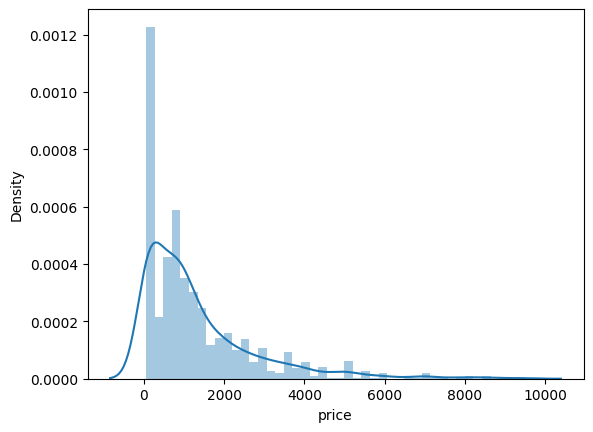

In [100]:
# Veamos la distribución de los precios

# Vemos que la mayoría de los precios se encuentran entre 0 y 500.000. Teniendo algunos outliers de varios millones, como por ejemplo
# el de casi 5 millones que vimos antes.

import seaborn as sns
sns.distplot(df_propiedades.price)

In [101]:
# Veamos algunas métricas de skewness y Kurtosis
# Skewness -> Calculo estadístico para ver la asimetría de una distribución. Al ser positiva nos dice que tenemos una
# "cola larga" hacia la derecha
# Kurtosis -> Cuantifica la forma de una función de probabilidad. Nos da informaciones de las colas de las distribuciones

#skewness and kurtosis
print("Skewness: %f" % df_propiedades.price.skew())
print("Kurtosis: %f" % df_propiedades.price.kurt())

Skewness: 2.134875
Kurtosis: 5.688853


<Axes: xlabel='surface_total', ylabel='price'>

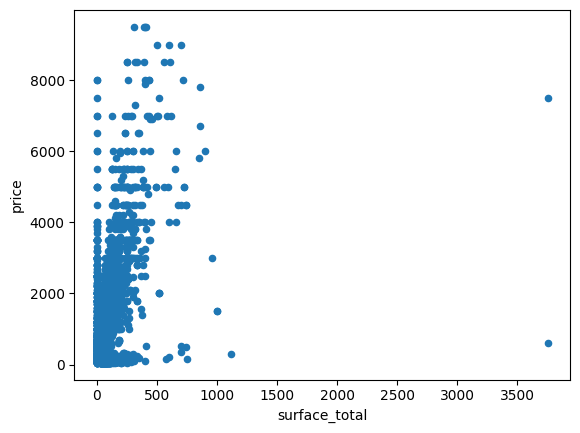

In [102]:
# Vamos a ver como se compara el precio de las propiedades con ciertas variables

# Precio por superficie
var = 'surface_total'
data = pd.concat([df_propiedades['price'], df_propiedades[var]], axis=1)
data.plot.scatter(x=var, y='price')

In [103]:
# Vemos algunos outliers, veamos la distribución de la variable
df_propiedades.surface_total.describe()

count    2950.000000
mean       92.649153
std       145.286095
min         0.000000
25%        33.000000
50%        60.000000
75%       110.000000
max      3753.000000
Name: surface_total, dtype: float64

In [104]:
# Vemos superficies con valor 0 y otras con espacios demasiado grandes, vamos a borrarlas
# Vamos a usar 10 metros cuadrados como minimo. 1000 metros cuadrados como máximo
df_propiedades = df_propiedades.loc[df_propiedades.surface_total > 10]
df_propiedades = df_propiedades.loc[df_propiedades.surface_total < 1000]
df_propiedades.surface_total.describe()

count    2349.000000
mean      111.598553
std       107.051056
min        17.000000
25%        47.000000
50%        75.000000
75%       131.000000
max       957.000000
Name: surface_total, dtype: float64

<Axes: xlabel='surface_total', ylabel='price'>

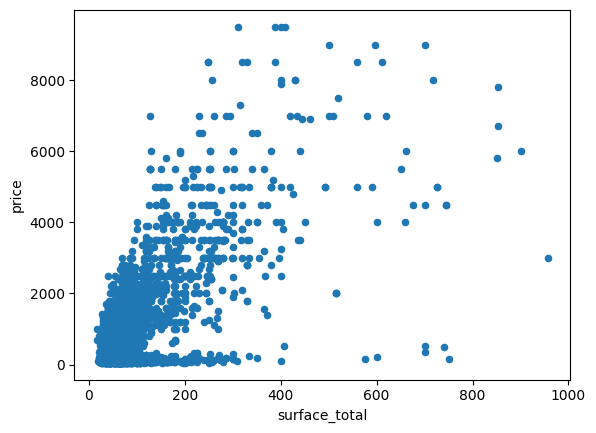

In [105]:
# Veamos la distribución ahora

# Precio por superficie
var = 'surface_total'
data = pd.concat([df_propiedades['price'], df_propiedades[var]], axis=1)
data.plot.scatter(x=var, y='price')

(-0.5, 10.5, 0.0, 10000.0)

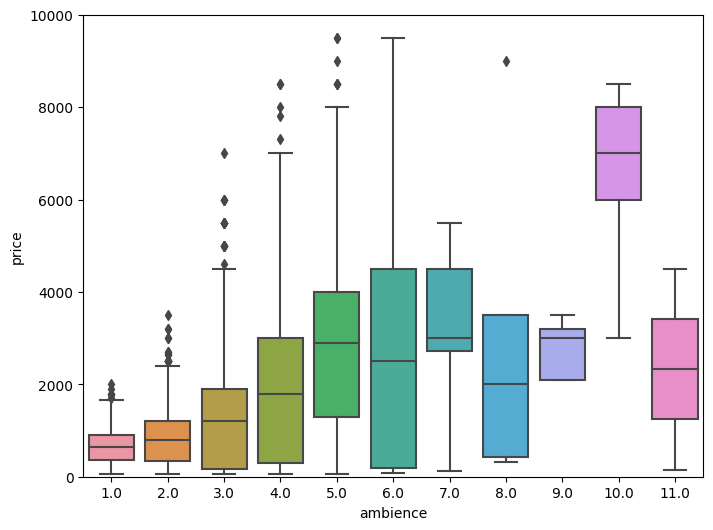

In [106]:
# Veamos algunas variables categóricas para ver como se comportan
import matplotlib.pyplot as plt

df_test = df_propiedades.loc[df_propiedades.ambience != 0]

var = 'ambience'
data = pd.concat([df_test['price'], df_test[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=10000)

(-0.5, 50.5, 0.0, 10000.0)

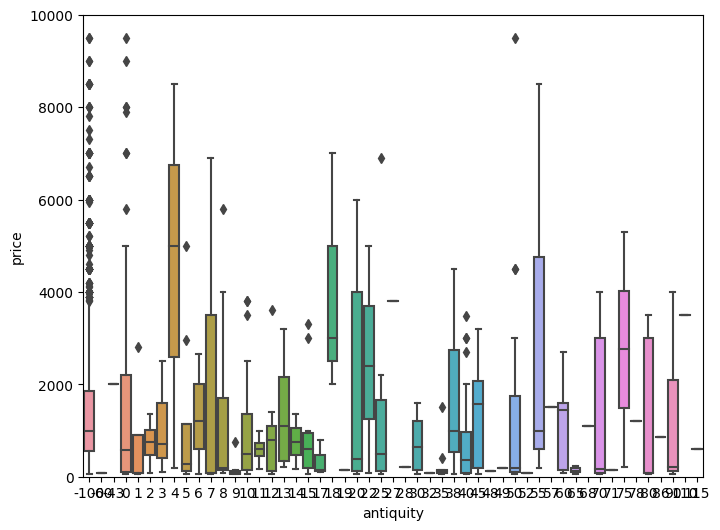

In [107]:
# Veamos algunas variables categóricas para ver como se comportan
import matplotlib.pyplot as plt

var = 'antiquity'
data = pd.concat([df_propiedades['price'], df_propiedades[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=10000)

In [108]:
# Veamos los barrios, aca tenemos muchos ID para los distintos barrios.
# Estos vienen de barrios.ts

# Debemos asegurar que el modelo, al ser entrenado, tenga todas las columnas que necesitamos. Independientemente que la información
# venga de la fuente o no

# Debido a esto, vamos a crear columnas del tipo OneHot Encoding para cada uno de los barrios
with open("../Utils/barrios.json") as json_file:
    barrios = json.load(json_file)

# Generamos columnas para cada uno de los barrios
for neighborhood in barrios.values():
    df_propiedades["location_neighbourhood_"+neighborhood] = 0

# No nos queda otra que iterar para ir seteando en 1 el barrio correcto. Es poco performante pero es la unica opcion
# Es como hacer un one hot encoding pero de forma manual.
for index, row in df_propiedades.iterrows():
    # Obtenemos el nombre del barrio
    barrio = barrios[str(row["location_neighbourhood"])]    
    df_propiedades.at[index, "location_neighbourhood_"+barrio] = 1

df_propiedades.drop(["location_neighbourhood"], axis=1, inplace=True)

/var/folders/nh/hlj82q8x3lb09bztb9v347pwp22f50/T/ipykernel_88068/3772027807.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_propiedades["location_neighbourhood_"+neighborhood] = 0
/var/folders/nh/hlj82q8x3lb09bztb9v347pwp22f50/T/ipykernel_88068/3772027807.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_propiedades["location_neighbourhood_"+neighborhood] = 0
/var/folders/nh/hlj82q8x3lb09bztb9v347pwp22f50/T/ipykernel_88068/3772027807.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the re

In [109]:
# Veamos como estan distribuidos los ambientes

# Vamos a borrar las entradas que no tienen información de ambientes
df_propiedades = df_propiedades.loc[df_propiedades.ambience != 0]
df_propiedades = df_propiedades.loc[df_propiedades.ambience.notna()]

df_propiedades.ambience.describe()

count    2188.000000
mean        2.914991
std         1.430958
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        11.000000
Name: ambience, dtype: float64

In [110]:
# Veamos como estan distribuidos los cuartos

# Vamos a borrar las entradas que no tienen información de cuartos

df_propiedades = df_propiedades.loc[df_propiedades.bedrooms != 0]
df_propiedades = df_propiedades.loc[df_propiedades.bedrooms.notna()]

df_propiedades.bedrooms.describe()

count    1943.000000
mean        2.012867
std         1.033596
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         7.000000
Name: bedrooms, dtype: float64

In [111]:
# Veamos como estan distribuidos los baños

# Vamos a rellenar los nulos con 1
df_propiedades['bathrooms'] = df_propiedades['bathrooms'].fillna(1)

df_propiedades.bathrooms.describe()

count    1943.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: bathrooms, dtype: float64

In [112]:
df_propiedades.bathrooms = pd.to_numeric(df_propiedades.bathrooms, errors="coerce")

/var/folders/nh/hlj82q8x3lb09bztb9v347pwp22f50/T/ipykernel_88068/3805268131.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["bathrooms", "building_apartments_floor"], axis=1, inplace=True)


<Axes: >

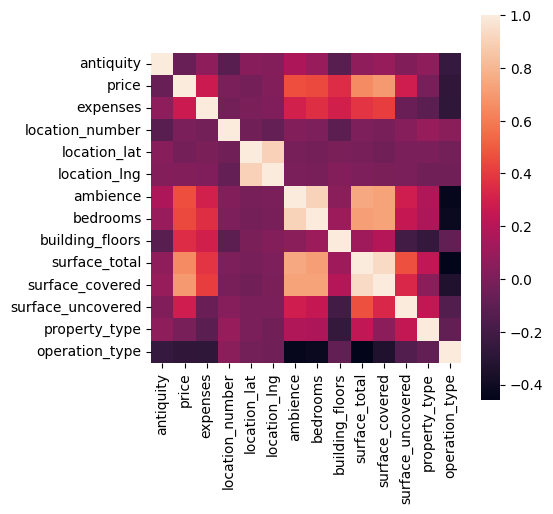

In [113]:
# Veamos una matriz de correlación

df_test = df_propiedades[df_propiedades.columns.drop(list(df_propiedades.filter(regex='location_neighbourhood')))]
df_test.drop(["bathrooms", "building_apartments_floor"], axis=1, inplace=True)

corrmat = df_test.select_dtypes([np.number]).corr(method="pearson", )
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corrmat, square=True)

In [114]:
# Vamos a generar un output para poder entrenar un modelo.

# Vamos a eliminar location_number y location_street ya que no pueden ser utilizadas por ahora

df_propiedades.drop(["location_street", "location_number"], axis=1, inplace=True)

In [115]:

# Para ver si hay algún tipo de inferencia, vamos a generar una nueva columna que haga un tracking de la cantidad de caracteres en el
# Título y la descripción. Para ver si una descripción más explayada ayuda al precio del alquiler.

# NOTA: Removemos esto por ahora, ya que no es viable pedir una descripcion cuando se realzia la consulta

"""
def count_characters(text):
    return len(text)

df_propiedades["title_char_count"] = df_propiedades.apply(lambda row: count_characters(row["title"]), axis=1)
df_propiedades["desc_char_count"] = df_propiedades.apply(lambda row: count_characters(row["description"]), axis=1)
df_propiedades.drop(["description", "title"], axis=1, inplace=True)
"""
df_propiedades.drop(["description", "title"], axis=1, inplace=True)

In [116]:
# Hagamos un análisis de los nulos, para ver en que columna nos falta más información

total = df_propiedades.isnull().sum().sort_values(ascending=False)
percent = (df_propiedades.isnull().sum()/df_propiedades.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(50)

,Total,Percent
building_apartments_floor,1736,0.893464
building_floors,1733,0.891920
expenses,1593,0.819866
surface_uncovered,1542,0.793618
surface_covered,1542,0.793618
location_lat,569,0.292846
location_lng,569,0.292846
location_neighbourhood_Palermo Hollywood,0,0.000000
location_neighbourhood_Palermo Boulevard,0,0.000000
location_neighbourhood_Palermo Chico,0,0.000000


In [117]:
# Vamos a borrar las columnas con un alto porcentaje de nulos. Digamos mayor a 35%, analizaremos el resto
# No vamos a borrar Bedrooms

df_propiedades.drop(["building_apartments_floor", "building_floors", "expenses", "surface_uncovered", "surface_covered"], axis=1, inplace=True)

In [118]:
# Borramos latitud y longitud
df_propiedades.drop(["location_lat", "location_lng"], axis=1, inplace=True)

# Borramos location_locality ya que van a ser todos Buenos Aires
df_propiedades.drop(["location_locality"], axis=1, inplace=True)


In [119]:
# Vamos a convertir las columnas True / False en 0 y 1 para que pueda ser utilizado en los modelos
df_propiedades.replace({False: 0, True: 1}, inplace=True)
df_propiedades

,_id,characteristincs_balcony,characteristincs_yard,characteristincs_rooftop,characteristincs_garage,amenities_amoblado,amenities_cancha_paddle,amenities_cancha_tenis,amenities_gimnasio,amenities_hidromasaje,amenities_laundry,amenities_microcine,amenities_parrilla,amenities_piscina,amenities_sala_de_juegos,amenities_sauna,amenities_solarium,amenities_spa,amenities_sum,amenities_estacionamiento_visitas,antiquity,price,ambience,bedrooms,bathrooms,surface_total,centros_comerciales_cercanos,parques_cercanos,escuelas_cercanas,property_type,operation_type,location_neighbourhood_Abasto,location_neighbourhood_Agronomía,location_neighbourhood_Almagro,location_neighbourhood_Almagro Norte,location_neighbourhood_Almagro Sur,location_neighbourhood_Balvanera,location_neighbourhood_Congreso,location_neighbourhood_Once,location_neighbourhood_Barracas,location_neighbourhood_Barrio Norte,location_neighbourhood_La isla,location_neighbourhood_Parque las Heras,location_neighbourhood_Recoleta,location_neighbourhood_Belgrano,location_neighbourhood_Belgrano Barrancas,location_neighbourhood_Belgrano C,location_neighbourhood_Belgrano La Imprenta,location_neighbourhood_Belgrano R,location_neighbourhood_Boedo,location_neighbourhood_Caballito,location_neighbourhood_Caballito Barrio Ingles,location_neighbourhood_Caballito Cid Campeador,location_neighbourhood_Caballito Norte,location_neighbourhood_Caballito Parque Rivadavia,location_neighbourhood_Caballito Primera Junta,location_neighbourhood_Caballito Sur,location_neighbourhood_Chacarita,location_neighbourhood_Coghlan,location_neighbourhood_Colegiales,location_neighbourhood_Constitución,location_neighbourhood_Flores,location_neighbourhood_Flores Norte,location_neighbourhood_Flores Sur,location_neighbourhood_Floresta,location_neighbourhood_Floresta Norte,location_neighbourhood_Floresta Sur,location_neighbourhood_La boca,location_neighbourhood_La paternal,location_neighbourhood_Liniers,location_neighbourhood_Mataderos,location_neighbourhood_Microcentro,location_neighbourhood_Monserrat,location_neighbourhood_Monte Castro,location_neighbourhood_Núñez,location_neighbourhood_Núñez Lomas,location_neighbourhood_Núñez River,location_neighbourhood_Palermo,location_neighbourhood_Palermo Botanico,location_neighbourhood_Palermo Boulevard,location_neighbourhood_Palermo Chico,location_neighbourhood_Palermo Hollywood,location_neighbourhood_Palermo Las Cañitas,location_neighbourhood_Palermo Pacifico,location_neighbourhood_Palermo Plaza Italia,location_neighbourhood_Palermo Soho,location_neighbourhood_Palermo Viejo,location_neighbourhood_Parque Avellaneda,location_neighbourhood_Parque Centenario,location_neighbourhood_Parque Chacabuco,location_neighbourhood_Parque Chas,location_neighbourhood_Parque Patricios,location_neighbourhood_Pompeya,location_neighbourhood_Primera Junta,location_neighbourhood_Puerto Madero,location_neighbourhood_Retiro,location_neighbourhood_Retiro Catalinas,location_neighbourhood_Retiro Plaza San Martín,location_neighbourhood_Saavedra,location_neighbourhood_San Cristóbal,location_neighbourhood_San Nicolás,location_neighbourhood_Tribunales,location_neighbourhood_San Telmo,location_neighbourhood_Velez Sarsfield,location_neighbourhood_Versalles,location_neighbourhood_Villa Crespo,location_neighbourhood_Villa del Parque,location_neighbourhood_Villa Devoto,location_neighbourhood_Villa General Mitre,location_neighbourhood_Villa Lugano,location_neighbourhood_Villa Luro,location_neighbourhood_Villa Ortúzar,location_neighbourhood_Villa Pueyrredón,location_neighbourhood_Villa Real,location_neighbourhood_Villa Riachuelo,location_neighbourhood_Villa Santa Rita,location_neighbourhood_Villa Soldati,location_neighbourhood_Villa Urquiza
3,64d0a7fcd7bb11178d077317,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62.500000,2.0,1.0,1,33,0,0,0,1,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,64d0a686d

In [120]:
# Vamos a hacer una prueba
df_final_test = df_propiedades.drop(["property_type", "operation_type"], axis=1)

# Aplicamos OneHotEncoding de las variables que apliquen
#df_final_test = pd.get_dummies(df_final_test)

# Pasamos los true/false a 0,1 nuevamente
df_final_test.replace({False: 0, True: 1}, inplace=True)

# Antiguedad -100 la pasamos a 0
df_final_test.loc[(df_final_test.antiquity==-100), ["antiquity"]] = 0

df_final_test.to_csv("cabaprop_source.csv")

In [121]:
# Nos conectamos a la mongo final

# Obtenemos las variables de entorno

import os
from dotenv import load_dotenv

PATH = os.getcwd()
PATH = PATH.replace("/Price/Exploration", "")

load_dotenv(PATH + "/.env")

import pymongo
import urllib.parse
import certifi
from pymongo.mongo_client import MongoClient
import json
import pandas as pd
import requests
import random

pd.set_option('display.max_columns', None)

username = urllib.parse.quote_plus(os.getenv("MONGO_USERNAME"))
password = urllib.parse.quote_plus(os.getenv("MONGO_PASSWORD"))

uri = "mongodb://{}:{}@{}:{}/?authSource={}&authMechanism={}".format(username, password, os.getenv("MONGO_HOST"),
                                            os.getenv("MONGO_PORT"), os.getenv("MONGO_DATABASE"), "SCRAM-SHA-1")

client = MongoClient(uri)

In [122]:
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [123]:
db = client[os.getenv("MONGO_DATABASE")]

In [125]:
from pymongo.errors import DuplicateKeyError
# Insertamos la información en nuestra DB final en mongo

final_collection = db.PriceProduction

data_to_insert = df_final_test.to_dict(orient="records")

for data in data_to_insert:
    try:
        final_collection.insert_one(data)
    # Esto significa que ya agregamos la propiedad antes, por lo que la actualizamos
    except DuplicateKeyError as e:
        target_id = data["_id"]
        res = final_collection.replace_one({"_id": target_id}, data)
